# 变量之间的关系
## 散点图

In [4]:
%matplotlib inline
from __future__ import print_function, division

import numpy as np
import pandas
import thinkstats2
import thinkplot
import nsfg
import brfss

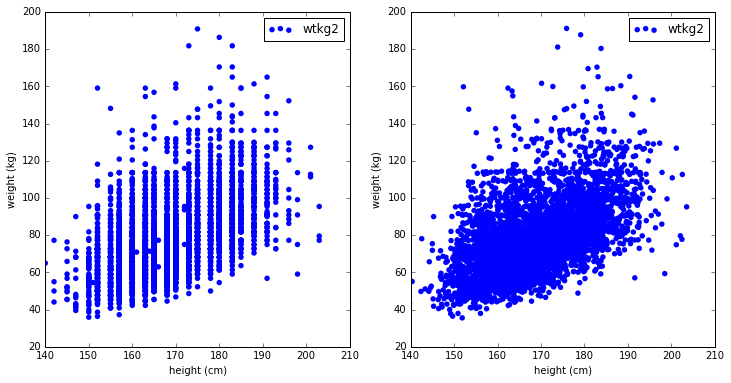

In [5]:
def GetHeightWeight(df, hjitter=0.0, wjitter=0.0):
    """Get sequences of height and weight.

    df: DataFrame with htm3 and wtkg2
    hjitter: float magnitude of random noise added to heights
    wjitter: float magnitude of random noise added to weights

    returns: tuple of sequences (heights, weights)
    """
    heights = df.htm3
    if hjitter:
        heights = thinkstats2.Jitter(heights, hjitter)

    weights = df.wtkg2
    if wjitter:
        weights = thinkstats2.Jitter(weights, wjitter)

    return heights, weights


def ScatterPlot(heights, weights, alpha=1.0):
    """Make a scatter plot and save it.

    heights: sequence of float
    weights: sequence of float
    alpha: float
    """
    thinkplot.Scatter(heights, weights, alpha=alpha)
    thinkplot.Config(xlabel='height (cm)',
                     ylabel='weight (kg)',
                     axis=[140, 210, 20, 200],
                     legend=False)


def HexBin(heights, weights, bins=None):
    """Make a hexbin plot and save it.

    heights: sequence of float
    weights: sequence of float
    bins: 'log' or None for linear
    """
    thinkplot.HexBin(heights, weights, bins=bins)
    thinkplot.Config(xlabel='height (cm)',
                     ylabel='weight (kg)',
                     axis=[140, 210, 20, 200],
                     legend=False)

df = brfss.ReadBrfss(nrows=None)
sample = thinkstats2.SampleRows(df, 5000)

# simple scatter plot
thinkplot.PrePlot(cols=2)
heights, weights = GetHeightWeight(sample)
ScatterPlot(heights, weights)

# scatter plot with jitter
thinkplot.SubPlot(2)
heights, weights = GetHeightWeight(sample, hjitter=1.3, wjitter=0.5)
ScatterPlot(heights, weights)

BRFSS调查参与者的体重与身高关系散点图，未抖动（左），抖动（右）。左图数据都成列聚集，之所以产生这种现象，是因为身高数据四舍五入到相邻的英寸。无法找回丢失的信息，但可以将数据进行`抖动（jittering）`。抖动减弱了四舍五入导致的视觉效果，使变量关系的形状更加清晰。但是抖动数据通常只应用于视觉效果，应该避免在分析时使用经过抖动的数据。

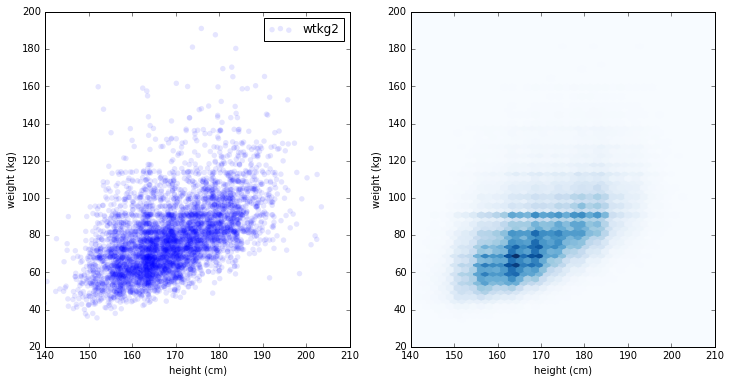

In [6]:
# with jitter and transparency
thinkplot.PrePlot(cols=2)
ScatterPlot(heights, weights, alpha=0.1)

# hexbin plot
thinkplot.SubPlot(2)
heights, weights = GetHeightWeight(df, hjitter=1.3, wjitter=0.5)
HexBin(heights, weights)

即便经过了抖动处理，散点图也不是展示数据的最佳方法。图中有很多重叠的点，遮盖了密集部分的数据，使离群点显得特别突出。这种效果称为饱和(saturation)。

对于中等规模的数据集，在散点图中设置透明效果很好。要处理更大数据集，可以使用hexbin图。hexbin图将图像划分为六角形的区间，将每个区间按照其中数据点的数量进行着色。

## 描述关系特征
对一个变量进行分区，绘制另一个变量的百分位数。

Fraction between 140 and 200 cm 0.996965884517


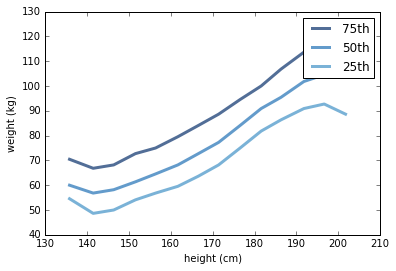

In [7]:
def BinnedPercentiles(df):
    """Bin the data by height and plot percentiles of weight for eachbin.

    df: DataFrame
    """
    cdf = thinkstats2.Cdf(df.htm3)
    print('Fraction between 140 and 200 cm', cdf[200] - cdf[140])

    bins = np.arange(135, 210, 5)
    indices = np.digitize(df.htm3, bins)
    groups = df.groupby(indices)

    heights = [group.htm3.mean() for i, group in groups][1:-1]
    cdfs = [thinkstats2.Cdf(group.wtkg2) for i, group in groups][1:-1]

    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weights = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(heights, weights, label=label)

    thinkplot.Config(root='scatter3',
                   xlabel='height (cm)',
                   ylabel='weight (kg)')

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
BinnedPercentiles(df)

上图展示了身高对应的体重百分位数。在140~200厘米，变量关系几乎是线性的。140~200厘米这个范围涵盖了超过99%的数据，因此，我们无需对极端值过多考虑。

## 相关性
相关性（correlation）是一个统计量，度量相关性的难度在于，需要比较的变量通常使用不同的单位。即便变量使用相同的单位，也可能来自不同的分布。两个解决方法：
- Pearson乘积矩相关系数：将每个值转换为标准分数（standard score）
- Spearman秩相关系数：将每个值都转换为秩

标准化（standardize）：$z_i=(x_i-\mu)/\sigma$，Z的值是无量纲的，其分布的均值为0，方差为1。

如果X符合正态分布，那么Z也符合正态分布。但如果X是偏斜的或包含离群值，那么Z也会偏斜或包含离群点。在这种情况下，使用百分位秩的稳健性更好。

## 协方差
协方差（covariance）可以度量两个变量共同变化的趋势。如果有两个序列X和Y：

$dx_i=x_i-\bar{x}$

$dy_i=y_i-\bar{y}$

$Cov(X,Y)=\frac{1}{n}\sum{dx_idy_i}$

n为两序列长度，$\bar{x}$和$\bar{y}$分别为两序列的样本均值。

## Pearson相关性
协方差的单位是X和Y的单位乘积，这一点很难理解。解决这一问题的方法之一是将偏差除以标准差，得到标准分数，然后计算标准分布的乘积：

$p_i=\frac{(x_i-\bar{x})}{S_x}\frac{(y_i-\bar{y})}{S_y}$

其中$S_x$和$S_y$分别是X和Y的标准差。这些乘积的均值为：$\rho=\frac{1}{n}\sum{p_i}$

Pearson相关性(Pearson's correlation):$\rho=\frac{Cov(X,Y)}{S_XS_Y}$

## Spearman秩相关
先计算每个值的秩(rank)，该值在排序样本中的索引。然后计算这些秩的Pearson相关性。

BRFSS数据的Spearman秩相关系数为0.54，比Pearson相关性0.51略高。导致差值产生的原因：

- 如果变量之间的关系是非线性的，那么Pearson相关性会低估相关性的强弱
- 如果所研究的分布之一是偏斜的或包含离群值，那么Pearson相关性在两个方向都可能受到影响，而Spearman秩相关的稳健性较好。

In [8]:
def Correlations(df):
    print('pandas cov', df.htm3.cov(df.wtkg2))
    #print('NumPy cov', np.cov(df.htm3, df.wtkg2, ddof=0))
    print('thinkstats2 Cov', thinkstats2.Cov(df.htm3, df.wtkg2))
    print()

    print('pandas corr', df.htm3.corr(df.wtkg2))
    #print('NumPy corrcoef', np.corrcoef(df.htm3, df.wtkg2, ddof=0))
    print('thinkstats2 Corr', thinkstats2.Corr(df.htm3, df.wtkg2))
    print()

    print('pandas corr spearman', df.htm3.corr(df.wtkg2, method='spearman'))
    print('thinkstats2 SpearmanCorr', 
          thinkstats2.SpearmanCorr(df.htm3, df.wtkg2))
    print('thinkstats2 SpearmanCorr log wtkg3', 
          thinkstats2.SpearmanCorr(df.htm3, np.log(df.wtkg2)))
    print()

    print('thinkstats2 Corr log wtkg3',
          thinkstats2.Corr(df.htm3, np.log(df.wtkg2)))

Correlations(df)

pandas cov 103.33316963
thinkstats2 Cov 103.332908577

pandas corr 0.508736478973
thinkstats2 Corr 0.508736478973

pandas corr spearman 0.540584626232
thinkstats2 SpearmanCorr 0.540584626232
thinkstats2 SpearmanCorr log wtkg3 0.540584626232

thinkstats2 Corr log wtkg3 0.531728260598
